In [32]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import glob as gl
import ali_offline_demod as dm
from scipy import signal
import scipy
import cmath
import imp
imp.reload(dm)

<module 'ali_offline_demod' from '/Users/yaqiongli/git/readout/host/ali_offline_demod.py'>

In [5]:
#get and save calibration first
#this is done using a manual way but mostly just try to understand which step is wrong
path='/Users/yaqiongli/Documents/ali_code/stanford_testing/20240205_first_light_data/fcenter_4250.0_20240205135358/'
initial_lo_sweep=np.load(path+'lo_sweep_initial_fcenter_4250.0_20240205135406.npy') #find initial lo sweep file
targeted_lo_sweep=np.load(path+'lo_sweep_targeted_2_fcenter_4250.0_20240205135707.npy')#find targeted sweep file
tone_freqs=np.load(path+'freq_list_lo_sweep_targeted_1_fcenter_4250.0_20240205135547.npy') #find tone freqs
path_ts='/Users/yaqiongli/Documents/ali_code/stanford_testing/20240205_first_light_data/'
ts_fr,Is_fr,Qs_fr=dm.read_data(path_ts+'ts_toneinit_fcenter_4250.0_20240205135358_t_20240205160326.hd5')

/Users/yaqiongli/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


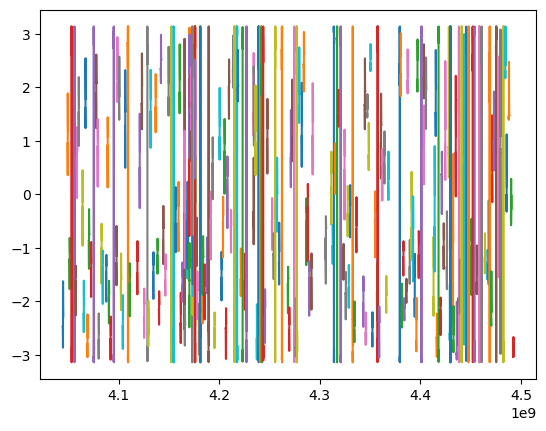

In [6]:
for i in range(targeted_lo_sweep.shape[1]):
    sweep=targeted_lo_sweep[:,i,:]
    plt.plot(sweep[0,:],[cmath.phase(x) for x in sweep[1,:]])
    
    

In [7]:
delay_region_start = 4.02e9  #Hz
delay_region_stop =  4.03e9 #Hz

3.1897455764058606e-08


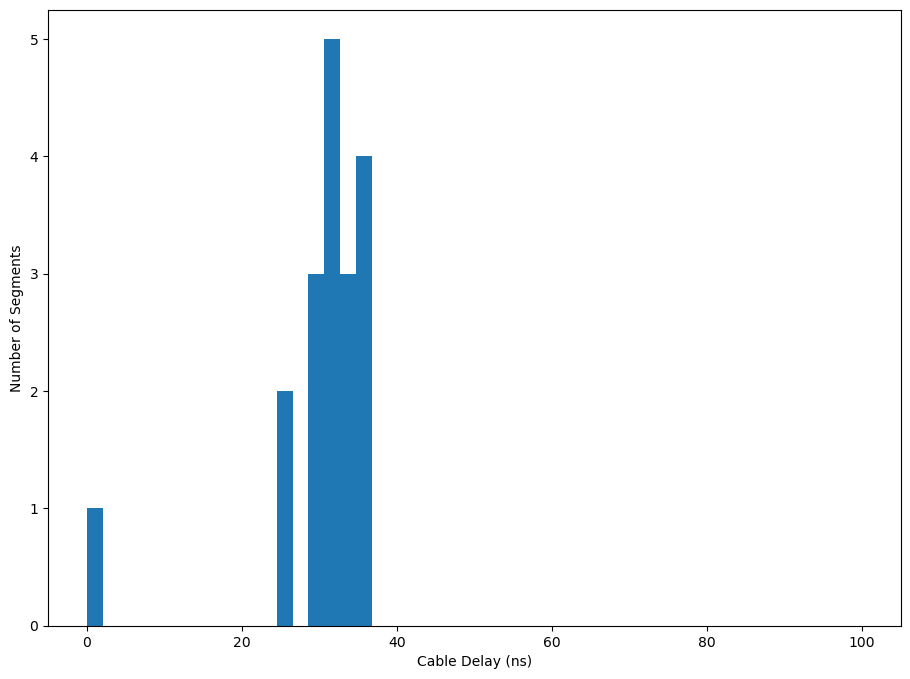

In [8]:
# Measure
delays = dm.measure_delay_test_given_freq(initial_lo_sweep,delay_region_start,delay_region_stop,plot=True)
print (np.median(delays))

In [9]:
#remove cable delay from target sweep and timestream
#plot S21 phase -> when there is no resonance it is the cable delay
targeted_lo_sweep_rm=dm.remove_delay(targeted_lo_sweep,27e-9)
IQ_stream_rm=dm.remove_delay_timestream(Is_fr+1j*Qs_fr,tone_freqs,27e-9)



In [10]:
calibration=dm.measure_circle_allch(targeted_lo_sweep_rm,tone_freqs) #finds circle center and initial phase for every channel

In [11]:
data_cal=dm.get_phase(IQ_stream_rm,calibration)


In [12]:
data_cal.shape[1]/488

21.0

In [13]:
%matplotlib qt 
dm.plot_timestream(ts_fr, data_cal, start_time = 15, end_time = 20, channel_nums = [50])

In [28]:
%matplotlib qt
t_start=5
t_stop=10
f_sawtooth = 15 #Hz

n_phi0 = dm.find_n_phi0(ts_fr[488*t_start:488*t_stop],data_cal[:,488*t_start:488*t_stop],f_sawtooth,plot=True)  #discard the first few seconds

print(f'n_phi0 = {n_phi0}')

bad channel 25
bad channel 141
bad channel 145
bad channel 153
bad channel 156
bad channel 160
bad channel 174
bad channel 178
bad channel 179
bad channel 187
bad channel 196
bad channel 200
bad channel 206
bad channel 224
bad channel 227
bad channel 228
bad channel 230
3.252778989532379
n_phi0 = 3.252778989532379


In [34]:
t0_array = np.array([])
for current_channel in range(len(data_cal)):
    t0 = dm.mea_reset_t0(ts_fr[488*t_start:488*t_stop],data_cal[current_channel,488*t_start:488*t_stop],f_sawtooth,plot=True)
    t0_array = np.append(t0_array,t0)
    
t0_med = np.nanmedian(t0_array)
print(t0_array)
print(t0_med)

[0.00748267 0.06595213 0.0653731  0.06331781 0.06540707 0.06524283
 0.06213044 0.06560415 0.02110276 0.00997175 0.06331781 0.06327499
 0.06560415 0.06269692 0.06537593 0.0623442  0.06432247 0.06581232
 0.06312461 0.06597239 0.06595213 0.06540707 0.04655428 0.06638047
 0.06331781 0.01436609 0.06312461 0.0632277  0.06597239 0.00951365
 0.01191505 0.06597239 0.06269692 0.03255771 0.03201267 0.03122228
 0.06540707 0.06529088 0.06281444 0.06609141 0.06331781 0.06597239
 0.04793968 0.06595213 0.03184511 0.0653731  0.03206623 0.06597239
 0.06595213 0.06651878 0.06595213 0.06597239 0.06540707 0.06247824
 0.06597239 0.06515915 0.02742472 0.06327499 0.06331781 0.06331781
 0.06349104 0.02055718 0.06529088 0.05969442 0.06540707 0.0653731
 0.03043421 0.06597239 0.0631604  0.02983333 0.04943617 0.0654082
 0.03109164 0.06597239 0.03135155 0.06595213 0.06269692 0.06597239
 0.0653731  0.0653731  0.01098666 0.06529088 0.03258139 0.0632277
 0.06331781 0.03009227 0.06327499 0.00011206 0.06331781 0.0659521

In [58]:
plt.hist(t0_array, np.linspace(0.05,0.07,10))

(array([ 0.,  5.,  3.,  2.,  3., 61., 47., 52.,  0.]),
 array([0.05      , 0.05222222, 0.05444444, 0.05666667, 0.05888889,
        0.06111111, 0.06333333, 0.06555556, 0.06777778, 0.07      ]),
 <BarContainer object of 9 artists>)

In [36]:
t_demods=[]
data_demods=[]
start_idx = dm.find_nearest_idx(ts_fr-ts_fr[0], t0_med)
for chan in range(data_cal.shape[0]):
    t_demod, data_demod = dm.demodulate(ts_fr[start_idx:]-ts_fr[start_idx], data_cal[chan, start_idx:], n_phi0, f_sawtooth, plot = True, plot_len = None)
    t_demods.append(t_demod)
    data_demod_unwrap=np.unwrap(data_demod,period=1)
    data_demods.append(data_demod_unwrap)
    
data_demods=np.vstack(data_demods)
t_demods=np.vstack(t_demods)

In [37]:
ch=49
plt.plot(t_demod,data_demods[ch],alpha=0.4)
plt.plot(ts_fr[start_idx:]-ts_fr[start_idx],data_cal[ch, start_idx:]*0.1,alpha=0.4)

In [39]:
fs=512e6/(2**20)
plt.plot(ts_fr-ts_fr[0],label='reality')
plt.plot(np.arange(ts_fr.shape[0])/fs, label='ideal, index*(1/488)')
plt.xlabel('index')
plt.ylabel('time')
plt.legend()

In [91]:
512e6/(2**20)

488.28125

In [55]:
#try deleting +-n points around the reset point
#remove anything close to data dropping
#the original function's algorithm only works when there's no frame(?) dropping
#so we can't do the chunk size way, so instead giving a time period
fs=512e6/(2**20)
def demodulate_new(t, sig, n_Phi0, n, f_sawtooth):
    #chunksize = len(sig) / t[len(t)-1] / f_sawtooth
    #n_chunks = int(len(t)//chunksize)
    period=1/f_sawtooth
    n_chunks=int(t[-1]/period)  
    slow_t = []
    slow_TOD = []
    for ichunk in range(n_chunks):
        t_start =period*ichunk+n/fs
        t_stop = period*(ichunk+1)-n/fs
        sig_chunk=sig[np.where((t>t_start)&(t<t_stop))]
        t_chunk=t[np.where((t>t_start)&(t<t_stop))]
        if t_chunk.shape[0]==0:
            continue
        t_diff=np.diff(t_chunk)
        t_diff=np.insert(t_diff, 0, 0)
        #print (t_chunk.shape)
        #print (t_diff.shape)
        t_chunk_sel=t_chunk[(t_diff >= 1./fs*0.8) & (t_diff <= 1./fs*1.2)]
        sig_chunk_sel=sig_chunk[(t_diff >= 1./fs*0.8) & (t_diff <=1./fs*1.2)]
        if t_chunk_sel.shape[0]<10:
            continue
        else:
            num = np.sum(sig_chunk_sel*np.sin(2*np.pi*n_Phi0*f_sawtooth*(t_chunk_sel-t_chunk_sel[0])))
            den = np.sum(sig_chunk_sel*np.cos(2*np.pi*n_Phi0*f_sawtooth*(t_chunk_sel-t_chunk_sel[0])))
            slow_TOD.append(np.arctan2(num, den))
            slow_t.append((t_start+t_stop)/2)
    
    
    #slow_t = slow_t[~np.isnan(slow_TOD)]
    #slow_TOD = np.unwrap(slow_TOD[~np.isnan(slow_TOD)])
    slow_t=np.array(slow_t)
    slow_TOD=np.array(slow_TOD)
    slow_TOD /= 2*np.pi # convert to Phi0
    #slow_TOD -= np.average(slow_TOD) # DC subtract
    #print(np.isnan(slow_TOD))
    
    """
    if plot == True:
        plt.plot(slow_t,slow_TOD,'.')
        plt.vlines(ts_start,0,0.4)
        print (range(ichunk))
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (arb.)')
        #plt.legend(loc='upper right')
        plt.title('Reconstructed Signal')
        plt.show()
    """
        
    return slow_t, slow_TOD

In [132]:
#try deleting +-n points around the reset point
#instead of removing the data, rearange the timestamp so that it's even
fs=512e6/(2**20)

def demodulate_rearrange_t(sig, n_Phi0, n, f_sawtooth):
    #chunksize = len(sig) / t[len(t)-1] / f_sawtooth
    #n_chunks = int(len(t)//chunksize)
    t=np.arange(sig.shape[0])/fs
    period=1/f_sawtooth
    n_chunks=int(t[-1]/period)  
    slow_t = []
    slow_TOD = []
    t_reset=0
    for ichunk in range(n_chunks):
        t_start =period*ichunk+n/fs
        t_stop = period*(ichunk+1)-n/fs
        sig_chunk=sig[np.where((t>t_start)&(t<t_stop))]
        t_chunk=t[np.where((t>t_start)&(t<t_stop))]
        t_reset=ichunk/f_sawtooth
        if t_chunk.shape[0]==0:
            continue
        else:
            #num = np.sum(sig_chunk*np.sin(2*np.pi*n_Phi0*f_sawtooth*(t_chunk-t_chunk[0])))
            #den = np.sum(sig_chunk*np.cos(2*np.pi*n_Phi0*f_sawtooth*(t_chunk-t_chunk[0])))
            num = np.sum(sig_chunk*np.sin(2*np.pi*n_Phi0*f_sawtooth*(t_chunk-t_reset)))
            den = np.sum(sig_chunk*np.cos(2*np.pi*n_Phi0*f_sawtooth*(t_chunk-t_reset)))
            slow_TOD.append(np.arctan2(num, den))
            slow_t.append((t_start+t_stop)/2)
    
    
    #slow_t = slow_t[~np.isnan(slow_TOD)]
    #slow_TOD = np.unwrap(slow_TOD[~np.isnan(slow_TOD)])
    slow_t=np.array(slow_t)
    slow_TOD=np.array(slow_TOD)
    slow_TOD /= 2*np.pi # convert to Phi0
    #slow_TOD -= np.average(slow_TOD) # DC subtract
    #print(np.isnan(slow_TOD))
    
    """
    if plot == True:
        plt.plot(slow_t,slow_TOD,'.')
        plt.vlines(ts_start,0,0.4)
        print (range(ichunk))
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (arb.)')
        #plt.legend(loc='upper right')
        plt.title('Reconstructed Signal')
        plt.show()
    """
        
    return slow_t, slow_TOD

In [56]:
t_demods_new=[]
data_demods_new=[]
#start_idx = dm.find_nearest_idx(ts_fr-ts_fr[0], t0_med+5./488)
start_idx = dm.find_nearest_idx(ts_fr-ts_fr[0], t0_med)
#start_idx = dm.find_nearest_idx(ts_fr-ts_fr[0], t0_med)
for chan in range(data_cal.shape[0]):
    n_phi0_ch=nphi0s[ch]
    t_demod, data_demod = demodulate_new(ts_fr[start_idx:]-ts_fr[start_idx], data_cal[chan, start_idx:], n_phi0_ch,5, f_sawtooth)
    t_demods_new.append(t_demod)
    data_demod_unwrap=np.unwrap(data_demod,period=1)
    data_demods_new.append(data_demod_unwrap)
    
data_demods_new=np.vstack(data_demods_new)
t_demods_new=np.vstack(t_demods_new)

In [133]:
t_demods_arange=[]
data_demods_arange=[]
#start_idx = dm.find_nearest_idx(ts_fr-ts_fr[0], t0_med+5./488)
start_idx = dm.find_nearest_idx(ts_fr-ts_fr[0], t0_med)
#start_idx = dm.find_nearest_idx(ts_fr-ts_fr[0], t0_med)
for chan in range(data_cal.shape[0]):
    n_phi0_ch=nphi0s[ch]
    t_demod, data_demod = demodulate_rearrange_t(data_cal[chan, start_idx:], n_phi0_ch,5, f_sawtooth)
    t_demods_arange.append(t_demod)
    data_demod_unwrap=np.unwrap(data_demod,period=1)
    data_demods_arange.append(data_demod_unwrap)
    
data_demods_arange=np.vstack(data_demods_arange)
t_demods_arange=np.vstack(t_demods_arange)




In [268]:
np.diff(ts_fr[480:495])

array([2.12860107e-03, 1.90305710e-03, 2.09689140e-03, 2.08640099e-03,
       1.98268890e-03, 2.01106071e-03, 2.11691856e-03, 5.96714020e-02,
       2.59876251e-05, 1.64508820e-05, 1.62124634e-05, 1.47819519e-05,
       1.54972076e-05, 2.28881836e-05])

In [46]:
for ch in range(t_demods.shape[0]):
    plt.plot(t_demods[ch],data_demods[ch],alpha=0.4,label='old')
    plt.plot(t_demods_new[ch],data_demods_new[ch]-0.3, alpha=0.05,label='new')
    #plt.plot(t_demods_t0[ch],data_demods_t0[ch],alpha=0.4,label='better t0')
    #plt.plot(ts_fr[start_idx:]-ts_fr[start_idx],data_cal[ch, start_idx:]*0.1,alpha=0.4)
    #plt.vlines(np.array(t_start)+4./488,0,0.4)
    #plt.legend()

In [138]:
ch=54
#plt.plot(t_demods[ch],data_demods[ch],alpha=0.4,label='old')
plt.plot(t_demods_new[ch],data_demods_new[ch]-0.6, alpha=0.4,label='orginal')
plt.plot(t_demods_arange[ch],data_demods_arange[ch], alpha=0.4,label='fixed demod')

    #plt.plot(t_demods_t0[ch],data_demods_t0[ch],alpha=0.4,label='better t0')
    #plt.plot(ts_fr[start_idx:]-ts_fr[start_idx],data_cal[ch, start_idx:]*0.1,alpha=0.4)
    #plt.vlines(np.array(t_start)+4./488,0,0.4)
plt.legend()

In [79]:
fs

488.28125

In [89]:
mend=np.zeros(data_demods_new.shape[1])

mend[::2] = 0
mend[1::2] = +0.05

mend_arange=np.zeros(data_demods_arange.shape[1])

mend_arange[::2] = 0
mend_arange[1::2] = +0.05

In [129]:
mend_arange=np.zeros(data_demods_arange.shape[1])
for i in range(data_demods_arange.shape[1]):
    shift=i*p_shift
    shift_act=shift-int(shift)
    mend_arange[i]=shift_act*n_phi0/(fs/15)

In [131]:
ch=54
#plt.plot(t_demods[ch],data_demods[ch],alpha=0.4,label='old')
#plt.plot(t_demods_new[ch],data_demods_new[ch]-0.6+mend, alpha=0.4,label='new')
plt.plot(t_demods_arange[ch],data_demods_arange[ch]-mend_arange, alpha=0.4,label='after removing 0.55 effect')
plt.plot(t_demods_arange[ch],data_demods_arange[ch]-0.1, alpha=0.4,label='before removing 0.55 effect')
plt.legend()

In [114]:
p_shift=fs/15-int(fs/15)

In [118]:
n_phi0

3.252778989532379

In [127]:
p_shift

0.5520833333333357

In [128]:
n_phi0/(fs/15)

0.09992537055843467